In [1]:
import pandas as pd
from isoweek import Week
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

# Sección B 

**1. ¿Cuántos millones de dólares se ganaron o perdieron a causa del programa? ¿Deberían expandirse a Canadá? Explica tu razonamiento y metodología.**

In [3]:
data_bm = pd.read_csv('data/bops_bm.csv')
data_online = pd.read_csv('data/bops_online.csv')

In [4]:
data_bm.dtypes

id (store)    int64
year          int64
month         int64
week          int64
usa           int64
after         int64
sales         int64
dtype: object

In [5]:
data_online.dtypes

id (DMA)    int64
year        int64
month       int64
week        int64
after       int64
close       int64
sales       int64
dtype: object

In [6]:
data_bm.head()

,id (store),year,month,week,usa,after,sales
0,1,2011,4,16,0,0,118691
1,1,2011,4,17,0,0,113804
2,1,2011,4,18,0,0,172104
3,1,2011,5,19,0,0,105591
4,1,2011,5,20,0,0,94884


In [7]:
data_online.head()

,id (DMA),year,month,week,after,close,sales
0,1,2011,4,17,0,1,18564
1,1,2011,4,18,0,1,30883
2,1,2011,5,19,0,1,37425
3,1,2011,5,20,0,1,32563
4,1,2011,5,21,0,1,35773


In [8]:
data_bm['sales'] = data_bm.sales.astype(float)
data_online['sales'] = data_online.sales.astype(float)

In [9]:
date_list = []
for i in range(data_bm.shape[0]):
    week = int(data_bm.week[i])
    year = int(data_bm.year[i])
    date = Week(year, week).monday()
    date_list.append(date)
data_bm['date'] = date_list

date_list = []
for i in range(data_online.shape[0]):
    week = int(data_online.week[i])
    year = int(data_online.year[i])
    date = Week(year, week).monday()
    date_list.append(date)
data_online['date'] = date_list

<AxesSubplot:xlabel='date', ylabel='sales'>

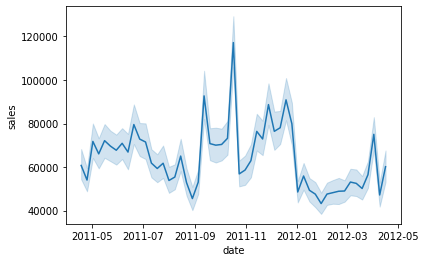

In [10]:
sns.lineplot(data=data_bm, x='date', y='sales')

<AxesSubplot:xlabel='date', ylabel='sales'>

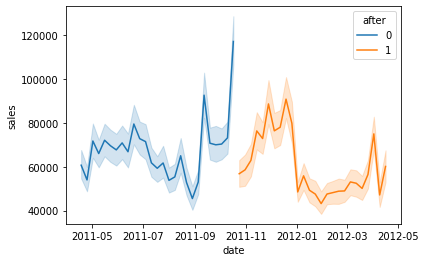

In [11]:
sns.lineplot(data=data_bm, x='date', y='sales', hue='after')

<AxesSubplot:xlabel='after', ylabel='sales'>

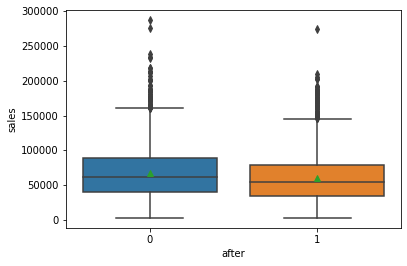

In [12]:
sns.boxplot(data=data_bm, y='sales', x='after', showmeans=True)

Notemos que al momento en que hay una disminución en las ventas en línea B&M una vez que se introduce BOPS, sin embargo, la dispersión no parece haber un gran cambio en la distribución de las ventas.

<AxesSubplot:xlabel='date', ylabel='sales'>

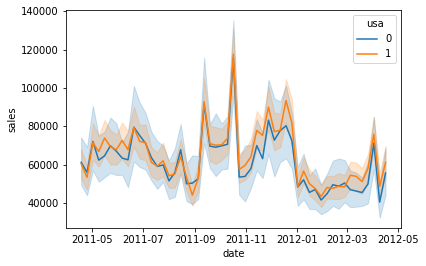

In [13]:
sns.lineplot(data=data_bm, x='date', y='sales', hue='usa')

No parece haber diferencia entre las ventas B&M entre USA y Canadá.

[Text(0.5, 1.0, 'Agrupación por semana'),
 Text(0.5, 0, 'No. semana'),
 Text(0, 0.5, 'Frecuencia')]

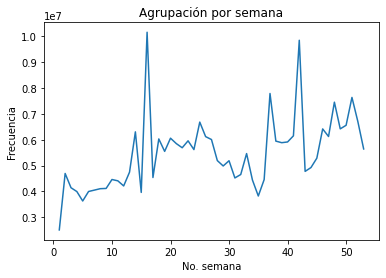

In [14]:
data_group = data_bm.groupby(by = ['week'])['sales'].\
    sum().to_frame(name = 'sales')
plot_del = sns.lineplot(data = data_group, 
                    x = 'week', y = 'sales')
plot_del.set(title='Agrupación por semana', xlabel = 'No. semana', ylabel = 'Frecuencia')

Para las ventas B&M:
- No parece haber cambio en la distribución de las ventas tras la llegada de BOPS
- No parece haber cambio en la distribución de las ventas entre USA y Canadá

<AxesSubplot:xlabel='date', ylabel='sales'>

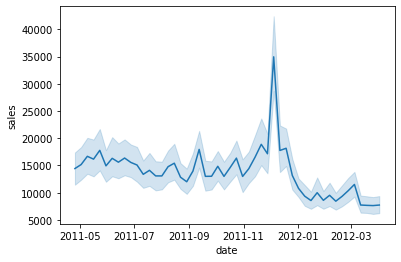

In [15]:
sns.lineplot(data=data_online, x='date', y='sales')

Las ventas en línea tienen un gran incremento tiempo después de la introducción a BOPS, disminuyen.

<AxesSubplot:xlabel='date', ylabel='sales'>

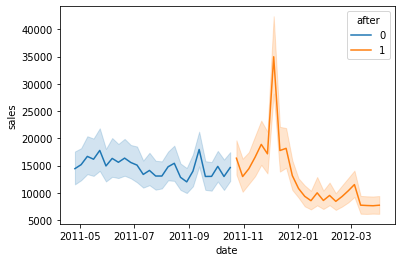

In [16]:
sns.lineplot(data=data_online, x='date', y='sales', hue='after')

<AxesSubplot:xlabel='after', ylabel='sales'>

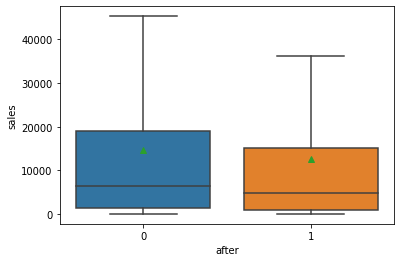

In [17]:
sns.boxplot(data=data_online, y='sales', x='after', showmeans=True, showfliers=False)

Por un lado, hay un gran pico en las ventas después de la aparición de BOPS. Por otro lado, no parece haber un cambio en la distribución de los datos ante la llegada de BOPS.

<AxesSubplot:xlabel='date', ylabel='sales'>

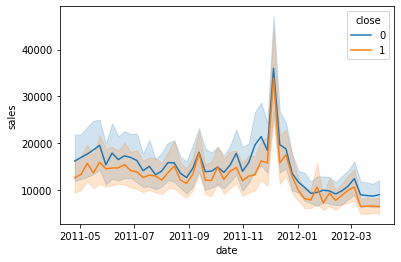

In [18]:
sns.lineplot(data=data_online, x='date', y='sales', hue='close')

<AxesSubplot:xlabel='close', ylabel='sales'>

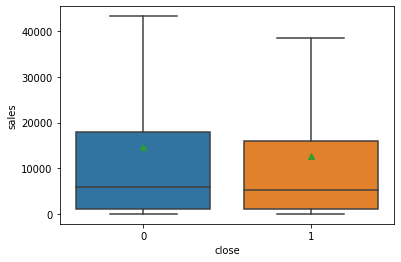

In [19]:
sns.boxplot(data=data_online, y='sales', x='close', showmeans=True, showfliers=False)

Ocurre un fenómeno similar al diferenciar entre si la tienda esta dentro de un radio de 50 millas cercana a una tienda o no.

Recordemos que estamos trabajando con datos temporales (tenemos una observación registrada a lo largo del tiempo), sin embargo, no tenemos suficientes datos como para poder estudiar/observar un fenómeno estacional a lo largo del tiempo, pues la única información que tenemos es de 6 meses previos a la introducción a BoPS y 6 posteriores a BOPS. Es por ello, que considero apropiado trabajar con un modelo de regresión lineal múltiple para analizar el efecto que la variable `close` y `after` en las ventas en línea y `usa` y `after` para las ventas en tiendas departamentales. Esto con el fin de emitir mi conclusión final. 

Me centro en estas únicas variables, pues no parece haber mucha información enriquecedora al diferenciar entre ID.

Dado que las variables son dicotómias, entonces no requieren de una estandarización o transformación.

In [20]:
# División de los datos en train y test
# ==============================================================================
X = data_bm.drop(columns='sales')[['usa','after']]
y = data_bm['sales']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
lm_model = LinearRegression()
lm_model.fit(X=X_train, y=y_train)
# Predicciones test
# ==============================================================================
predicciones = lm_model.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")

print("Coeficientes: ")
print(lm_model.coef_)

coef_bm_after_1 = lm_model.coef_[0,1]


El error (rmse) de test es: 36442.51713230236
Coeficientes: 
[[ 4164.14432917 -7801.90989723]]


- Parece haber una contribución positiva en las ventas promedio de $\$4,164$ USD si la tienda está localizada en USA.
- Parece haber una contribución negativa en las ventas promedio de $\$7,801$ USD tras la introducción de BOPS.

In [21]:
# División de los datos en train y test
# ==============================================================================
X = data_online.drop(columns='sales')[['close','after']]
y = data_online['sales']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
lm_model = LinearRegression()
lm_model.fit(X=X_train, y=y_train)
# Predicciones test
# ==============================================================================
predicciones = lm_model.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")

print("Coeficientes: ")
print(lm_model.coef_)

coef_online_after_1 = lm_model.coef_[0,1]


El error (rmse) de test es: 21685.132234863893
Coeficientes: 
[[-1906.76449198 -1391.09760889]]


- Parece haber una contribución negativa en las **ventas promedio** de $\$1,906$ USD si la compra fue realizada cerca de una tienda departamental (50 millas de radio). Esto puede ser interpretado de la siguiente manera: si el comprador se encuentra cerca (a lo más 50 millas) de una tienda, irá a comprar en dicha tienda, en caso contrario hará la compra en línea (recordemos que este es un resultado promedio).
- Parece haber una contribución negativa en las ventas promedio de $\$1,391$ USD tras la introducción de BOPS. Lo cual se puede interpretar de la siguiente manera: dado el comportamiento de los consumidores de esta tienda, si se encuentran cercanos a una tienda departamental irán a realizar sus compras físicamente, en caso contrario, no lo harán. Por lo que, la opción de comprar en línea y recoger no es muy viable, según esta hipótesis para entender el comportamiento del consumidor.

Si suponemos como nivel base, las ventas promedio mensuales que tenía Home and Kitchen antes de la pandemia en las tiendas departamentales. Entonces las pérdidas atribuidas a BOPS en las tiendas departamentales son de:

In [22]:
print('Pérdidas: $', round((coef_bm_after_1)*sum(data_bm.after)))

Pérdidas: $ -17694732


Si suponemos como nivel base, las ventas promedio mensuales que tenía Home and Kitchen antes de la pandemia en las tiendas en línea. Entonces las pérdidas atribuidas a BOPS en las tiendas departamentales son de:

In [23]:
print('Pérdidas: $', round((coef_online_after_1)*sum(data_online.after)))

Pérdidas: $ -7303262


In [24]:
print('Pérdidas totales: $', round( (coef_online_after_1)*sum(data_online.after) + coef_bm_after_1*sum(data_bm.after) ))

Pérdidas totales: $ -24997994


Si suponemos que el mercado de Canadá es similar al de USA, entonces no recomiendo expandir el programa a Canadá.